<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.880 · Trabajo final de máster · Área 3</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Sistema de detección y monitorización de amenazas de ciberseguridad utilizando aprendizaje profundo y la pila Elastic

_Cybersecurity threat detection and monitoring system using Deep Learning and the Elastic Stack_

**Autor: Alejandro Arzola García**

## 1. Contexto

El sistema de detección de amenazas de ciberseguridad que se desarrolla en este trabajo final de máster debe ser capaz de analizar múltiples eventos de seguridad de cualquier dispositivo con sistema operativo _Windows_ y determinar si se trata de una amenaza o no.

En este cuaderno de _jupyter_, vamos a llevar a cabo todos los pasos necesarios para construir y entrenar una red neuronal que nos permita lograr este objetivo.

## 2. Carga de librerías

El primer paso que debemos realizar es cargar todas las librerías necesarias:

In [1]:
import numpy as np
import pandas as pd

import xml.etree.ElementTree as ET

import event as EV

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 12]

## 3. Obtención y carga de los datos

Los dispositivos con sistema operativo Windows (incluidos servidores con Directorio Activo), disponen de una herramienta de registro de eventos donde se almacenan todas las acciones que realizan los diferentes usuarios y las interacciones con el propio sistema operativo. Para acceder a la herramienta debemos seguir los siguientes pasos:
1.	Abrir el menú de Inicio de Windows.
2.	Escribir el siguiente texto en el cuadro de búsqueda: “Visor de eventos”.

Una vez abierta la herramienta “Visor de eventos”, vemos que en el lado izquierdo tenemos un menú con diferentes categorías. En nuestro caso, nos vamos a enfocar en los “Registros de Windows” y, dentro de esta categoría, los eventos de seguridad.

Al entrar dentro de cualquier categoría, en la barra de herramientas del lateral derecho, tenemos la opción “Guardar todos los eventos como…” que nos permite exportar todos los eventos de ese dispositivo en diferentes formatos (_csv, txt, xml o evtx_).

Siguiendo todos estos pasos, he podido exportar en formato xml casi 30.000 eventos de seguridad de mi ordenador de sobremesa. Este será el conjunto de datos que nos permita entrenar nuestra red neuronal.

A continuación, procedemos a cargar el fichero xml con todos estos eventos. Además, utilizaremos una librería de las que hemos cargado previamente para parsear de forma muy sencilla el fichero.

La librería se llama [xml.etree.ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html) y se trata de una API sencilla y eficiente para parsear y crear datos XML.

**Nota:** Los eventos pueden contener cierta información confidencial, por lo que puede suponer un riesgo exponer todos estos eventos en cualquier repositorio de internet. Por tanto, se ha evitado subir el directorio `ejemplo-eventos-xml` a este repositorio, que contiene diferentes ficheros xml con eventos reales de un ordenador con _Windows_.

In [4]:
# Abrimos el fichero xml, leemos el contenido y lo parseamos
with open('../ejemplo-eventos-xml/events_export.xml', 'r') as reader:
    raw_xml = reader.read()
    parsed_xml = ET.fromstring(raw_xml)

A continuación, vamos a transformar el xml en un dataframe de Pandas para facilitar su análisis. Para esto, hemos creado una clase en Python (`event.py`, disponible en este repositorio) que extrae la información que queremos del xml:

In [5]:
# Transformamos cada evento xml en un diccionario de python
# utilizando la clase Event que hemos implementado
rows = []
for event in parsed_xml:
        e = EV.Event(event)
        rows.append(e.createRow())
        
# Creamos el dataframe de Pandas
data = pd.DataFrame(rows)

## 4. Pre-procesamiento

Ahora que ya hemos cargado los datos y los tenemos agrupados en un dataframe, vamos a realizar un primer análisis para conocer mejor nuestros propios datos.

Comenzamos la exploración mostrando algunos registros, para conocer el número de atributos, así como el número exacto de registros. También vamos a verificar la presencia de valores nulos.

In [6]:
# Mostramos los 5 primeros registros de nuestro dataset
data.head(5)

eventID                   timeCreated processID threadID   userName  \
0    4798  2021-05-01T09:20:08.8228171Z       816     2700  Alejandro   
1    4798  2021-05-01T09:20:08.8224581Z       816    12536  Alejandro   
2    5382  2021-05-01T09:20:00.5170840Z       816    12536  Alejandro   
3    5382  2021-05-01T09:20:00.5168421Z       816    12536  Alejandro   
4    5382  2021-05-01T09:20:00.5165951Z       816    12536  Alejandro   

  domainName            callerProcessName  \
0     PC-ALE  C:\Windows\System32\mmc.exe   
1     PC-ALE      C:\Windows\explorer.exe   
2     PC-ALE                  Desconocido   
3     PC-ALE                  Desconocido   
4     PC-ALE                  Desconocido   

                                         longMessage        level  \
0  Se enumeró la pertenencia a grupos locales de ...  Información   
1  Se enumeró la pertenencia a grupos locales de ...  Información   
2  Se leyeron las credenciales de bóveda. \n\nAsu...  Información   
3  Se leyeron las credenciales de bóveda. \n\nAsu...  Información   
4  Se leyeron las credenciales de bóveda. \n\nAsu...  Información   

                      task  
0  User Account Management  
1  User Account Management  
2  User Account Management  
3  User Account Management  
4  User Account Management

In [7]:
# Mostramos el número de atributos (columnas) y de registros (filas)
# de nuestro dataset
print("Número de registros: {}".format(data.shape[0]))
print("Número de atributos: {}".format(data.shape[1]))

Número de registros: 27588
Número de atributos: 10


In [8]:
# Comprobamos posibles valores nulos
nulos = data.isnull().sum().sum()
print("Número de valores nulos: {}".format(nulos))

Número de valores nulos: 0


Como podemos ver, disponemos de 10 atributos para un total de 27.588 registros. También es importante recalcar que no existen valores nulos.

Uno de esos atributos es `eventID`, que nos indica el identificador del tipo de eventos que le han asignado los desarrolladores del propio sistema operativo. El listado completo con el resumen del evento se puede consultar en el siguiente enlace de la documentación oficial de _Microsoft_: https://docs.microsoft.com/es-es/windows-server/identity/ad-ds/plan/appendix-l--events-to-monitor.

Vamos a comprobar los identificadores de evento que tenemos en nuestro conjunto de datos:

In [9]:
data["eventID"].unique()

array(['4798', '5382', '4672', '4624', '5379', '4799', '4634', '4648',
       '5059', '5061', '5058', '4647', '4797', '4905', '4904', '4616',
       '5381', '5024', '5033', '4902', '4608', '4688', '4826', '4696',
       '1100', '4907', '4625'], dtype=object)

| eventID | Resumen del evento                                           | Importancia crítica potencial (Según Microsoft) |
|:-------:|:-------------------------------------------------------------|:-----------------------------:|
| 4798    | Se enumeró la pertenencia a un grupo local de un usuario | Baja |
| 5382    | Se leyeron las credenciales de la bóveda | Baja |
| 4672    | Privilegios especiales asignados al nuevo inicio de sesión   | Baja |
| 4624    | Se inició sesión correctamente en una cuenta | Baja |
| 5379    | Se leyeron las credenciales de Credential Manager | Baja |
| 4799    | Se enumeró una pertenencia a un grupo local con seguridad habilitada | Baja |
| 4634    | Se cerró sesión en una cuenta | Baja |
| 4648    | Se intentó iniciar sesión con credenciales explícitas | Baja |
| 5059    | Operación de migración de clave | Baja |
| 5061    | Operación criptográfica | Baja |
| 5058    | Operación de archivo de clave | Baja |
| 4647    | Cierre de sesión iniciada por el usuario | Baja |
| 4797    | Se intentó consultar la existencia de una contraseña en blanco para una cuenta | Baja |
| 4905    | Se intentó anular el registro de un origen de evento de seguridad | Baja |
| 4904    | Se intentó registrar un origen de evento de seguridad | Baja |
| 4616    | Se cambió la hora del sistema | Baja |
| 5381    | Se leyeron las credenciales de la bóveda | Baja |
| 5024    | El servicio de Firewall de Windows se ha iniciado correctamente | Baja |
| 5033    | El controlador de Firewall de Windows se inició correctamente | Baja |
| 4902    | Se creó la tabla de directiva de auditoría por usuario | Baja |
| 4608    | Windows se está iniciando | Baja |
| 4688    | Se ha creado un nuevo proceso | Baja |
| 4826    | Datos de configuración de arranque cargados | Baja |
| 4696    | Se asignó un token primario al proceso | Baja |
| 1100    | El servicio de registro de eventos se ha cerrado | Baja |
| 4625    | No se pudo iniciar sesión en una cuenta | Baja |
| 4907    | Se cambió la configuración de auditoría del objeto | **Media** |

Como podemos ver en la tabla anterior, únicamente tenemos un tipo de evento que Windows considera que tiene una importancia crítica potencial media (4907), el resto son eventos que no son muy importantes. No obstante, el evento con identificador 4625 hace referencia a intentos de inicio de sesión incorrectos.

Estos dos tipos de eventos los voy a filtrar ya que considero interesante que nuestro sistema nos informe de que se han producido este tipo de eventos, así como del resto que no aparecen en esta lista. Vamos a comprobar cuantos eventos vamos a suprimir:

In [10]:
len(data[(data['eventID'] == '4625') | (data['eventID'] == '4907')])

2605

In [11]:
# Obtenemos los índices de los eventos a suprimir
indexNames = data[(data['eventID'] == '4625') | (data['eventID'] == '4907')].index
data.drop(indexNames, inplace=True)

print("Número de registros: {}".format(data.shape[0]))

Número de registros: 24983


Las redes neuronales artificiales, como el resto de los modelos de aprendizaje automático, requieren que los datos de entrada estén en un formato específico para poder trabajar de forma correcta. Concretamente estos deben estar en formato numérico y se recomienda que estén estandarizados.

Teniendo en cuenta esta premisa, debemos procesar nuestros atributos para convertirlos a variables numéricas y estandarizarlos. En este proceso se utilizarán librerías de [keras](https://keras.io/) y [sklearn](https://scikit-learn.org/stable/).


La variable timeCreated es la única que no vamos a procesar con la red neuronal. Las variables eventID y processID son variables numéricas, pero que realmente son variables cualitativas, por lo que las trataremos como si fueran texto. Con estos dos atributos y el resto de los atributos de tipo texto aplicaremos un procedimiento de tokenización de las palabras. La única variable numérica que tendremos que estandarizar será threadID.

Además, para poder repetir el proceso, vamos a almacenar estos modelos (Tokenizador y Scaler) en local utilizando la librería `pickle`.

In [12]:
# Creamos función para tokenizar un atributo y almacenar el tokenizador
def tokenize_attribute(attribute, name):
    # Creamos y entrenamos el tokenizador
    t = Tokenizer()
    t.fit_on_texts(attribute)
    
    # Guardamos en local el tokenizador
    with open('../generador-eventos/dl_models/' + name + '.pickle', 'wb') as handle:
        pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    # Transformamos nuestros datos
    tokenized_attribute = t.texts_to_matrix(attribute, mode='count')
    
    return pd.DataFrame(tokenized_attribute)

In [13]:
# Atributos que queremos tokenizar
attr_to_tokenize = ['eventID', 'processID', 'userName', 'domainName', 
                    'callerProcessName', 'longMessage', 'level', 'task']

# Nuevo dataframe con los datos procesados
processed_data = pd.DataFrame()

# Añadimos los datos procesados
for attr in attr_to_tokenize:
    processed_data = pd.concat([processed_data, tokenize_attribute(data[attr], attr)], axis=1)

In [14]:
# Estandarizamos el atributo threadID
threadID = data.iloc[:, 3].values

scaler = StandardScaler().fit(threadID.reshape(-1,1))

processed_data['threadID'] = scaler.transform(threadID.reshape(-1,1))

# Guardamos en local el scaler
with open('../generador-eventos/dl_models/threadID.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

Después de todo este procesamiento de nuestros datos, ya estamos listos para entrenar nuestra red neuronal. Pero antes, vamos a echar un vistazo a nuestro conjunto de datos después del procesamiento:

In [15]:
processed_data.head(5)

0    1    2    3    4    5    6    7    8    9  ...   13   14   15   16  \
0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

    17   18   19   20   21  threadID  
0  0.0  0.0  0.0  0.0  0.0 -1.455124  
1  0.0  0.0  0.0  0.0  0.0 -0.001994  
2  0.0  0.0  0.0  0.0  0.0 -0.001994  
3  0.0  0.0  0.0  0.0  0.0 -0.001994  
4  0.0  0.0  0.0  0.0  0.0 -0.001994  

[5 rows x 1992 columns]

## 5. Conjuntos de entrenamiento y validación

En este apartado vamos a construir nuestro conjunto de entrenamiento y el de validación.

Como hemos comprobado anteriormente, nuestros datos originales no están etiquetados, es decir, no tenemos una clase que nos indique si ese registro es una amenaza o un ataque de ciberseguridad. Sin embargo, para utilizar las funcionalidades de keras, debemos tener una variable que represente la clase a la que pertenece cada registro. Debido a esto, tenemos que añadir una nueva columna cuyo valor será 0.

Para los conjuntos de entrenamiento y validación, utilizaremos una proporción 50%-50% respectivamente.

In [16]:
# Añadimos etiqueta igual para todos nuestros registros
processed_data['label'] = 0

# Transformamos a numpy array
features = processed_data.iloc[:,:processed_data.shape[1]-1].values
labels = processed_data.iloc[:,processed_data.shape[1]-1:processed_data.shape[1]].values

# Aplicamos la división de conjuntos
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.5, shuffle=True)

Mostramos las medidas de nuestros conjuntos de datos:

In [17]:
# Mostramos las medidas del conjunto de entrenamiento y de conjunto de validación
print("--- Medidas de los conjuntos de datos ---\n")
print("* Entrenamiento:") 
print("\t- Características (X_train): {}".format(X_train.shape))
print("\t- Etiquetas (y_train): {}".format(y_train.shape))
print("\n* Validación: ")
print("\t- Características (X_val): {}".format(X_val.shape))
print("\t- Etiquetas (y_val): {}".format(y_val.shape))

--- Medidas de los conjuntos de datos ---

* Entrenamiento:
	- Características (X_train): (12491, 1992)
	- Etiquetas (y_train): (12491, 1)

* Validación: 
	- Características (X_val): (12492, 1992)
	- Etiquetas (y_val): (12492, 1)


## 6. Red neuronal: Autoencoder

Los Autoencoders son un tipo de red neuronal completamente conectada que tiene por objetivo reproducir los datos de entrada. Normalmente se divide en dos componentes: el codificador (*encoder*), el cual mapea el espacio de entrada a un espacio de menor dimensión (también llamado en inglés *latent space*), y el decodificador (*decoder*), el cual mapea desde este espacio más pequeño a uno igual al espacio de entrada (también llamado en inglés *reconstruction space*). 

Los Autoencoders son también un método común para la detección de anomalías en un conjunto de datos: el modelo aprende a reconstruir los datos de entrada, por lo que podemos hacer que aprenda a reconstruir únicamente datos 'buenos' o normales. El modelo nos proporcionará un "error de reconstrucción", basado en la media de la diferencia cuadrática entre los datos de entrada (X) y la reconstrucción hecha o predicción (X'). 

$$\textrm{mse}(X, X') = \frac{1}{n} \sum^{n}_{1=1} (X_i - X'_i)^2$$

Con este error, podremos asignar un umbral (*threshold*) a partir del cual el modelo considerará que la reconstrucción es buena o no. Así, usando los datos de test, si el error de reconstrucción es superior al umbral fijado, se considerará ese dato como anómalo o malicioso. Para ello es necesario que tanto los datos de entrenamiento como los de validación incluyan únicamente datos 'buenos' (clase benigna).

Tal y como hemos comentado, nuestro modelo estará formado por el codificador y el decodificador. Dado que se trata de una reconstrucción, las capas ocultas del codificador tendrán número decreciente de neuronas hasta la dimensión mínima, y el codificador reconstruirá de nuevo esas capas en valor ascendente. En el modelo a definir en este apartado, el autoencoder utilizará internamente 12 capas ocultas con 1000, 500, 250, 125, 60, 30, 30, 60, 125, 250, 500, 1000 neuronas, además de las capas de entrada y salida.

In [18]:
# Construimos la capa de entrada. El número de neuronas en esta capa será igual a la 
# dimensión de nuestro dataset
input_layer = Input(shape=(X_train.shape[1],))

# Capas ocultas del codificador (encoder)
encoder_num_neurons = [500, 250, 125, 60, 30]
encoded = Dense(1000, activation='tanh')(input_layer)
for i in encoder_num_neurons:
    encoded = Dense(i, activation='tanh')(encoded)
    
# Capas ocultas del decodificador (decoder)
decoder_num_neurons = [60, 125, 250, 500, 1000]
decoded = Dense(30, activation='tanh')(encoded)
for i in decoder_num_neurons:
    decoded = Dense(i, activation='tanh')(decoded)

# Capa de salida
decoded = Dense(X_train.shape[1])(decoded)

# Construimos el autoencoder
autoencoder = Model(input_layer, decoded)

# Mostramos la estructura de capas del modelo
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1992)]            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1993000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 125)               31375     
_________________________________________________________________
dense_4 (Dense)              (None, 60)                7560      
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1830  

A continuación compilaremos y entrenaremos el modelo, aplicando la técnica de *Early Stopping* para evitar que el error en los datos de validación aumente y haya sobreentrenamiento. Esta técnica se encargará de monitorizar la pérdida durante la validación cada 5 épocas, de modo que el modelo recupere los pesos de la época con mejor valor de esta pérdida.

In [19]:
# Definimos el optimizador Adam con velocidad de aprendizaje 0.001
opt = keras.optimizers.Adam(learning_rate=0.001)

# Compilamos el modelo con el optimizador que acabamos de crear y función de pérdida MSE
autoencoder.compile(optimizer=opt, loss="mean_squared_error")

# Definimos el EarlyStopping para monitoriar la pérdida durante la validación (val_loss), 
# validación cada 5 épocas y que recupere los pesos de la mejor época
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamos el modelo
autoencoder_result = autoencoder.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping])

Epoch 1/25
391/391 [==============================] - 27s 68ms/step - loss: 3.5545e-04 - val_loss: 6.5181e-08
Epoch 2/25
391/391 [==============================] - 24s 61ms/step - loss: 6.9511e-08 - val_loss: 3.4208e-08
Epoch 3/25
391/391 [==============================] - 24s 61ms/step - loss: 7.5250e-08 - val_loss: 7.8150e-08
Epoch 4/25
391/391 [==============================] - 24s 62ms/step - loss: 9.4084e-08 - val_loss: 6.4985e-08
Epoch 5/25
391/391 [==============================] - 23s 60ms/step - loss: 1.3589e-07 - val_loss: 1.2190e-07
Epoch 6/25
391/391 [==============================] - 22s 56ms/step - loss: 6.4940e-08 - val_loss: 3.6863e-08
Epoch 7/25
391/391 [==============================] - 22s 57ms/step - loss: 1.4325e-07 - val_loss: 2.7700e-08
Epoch 8/25
391/391 [==============================] - 25s 63ms/step - loss: 1.4047e-07 - val_loss: 1.1865e-08
Epoch 9/25
391/391 [==============================] - 24s 62ms/step - loss: 1.2173e-07 - val_loss: 1.4007e-08
Epoch 10/2

Una vez entrenado el modelo, podemos obtener la predicción para los datos de validación y calcular el error de reconstrucción en cada caso. El error en la validación será el que nos permita definir más adelante el umbral a partir del cual consideramos que los datos son anómalos o maliciosos.

In [20]:
# Calculamos la predicción del modelo autoencoder para el conjunto de validación
val_pred_x = autoencoder.predict(X_val)

# Calculamos el error de reconstrucción
val_error_rec = np.mean(np.power(X_val - val_pred_x, 2), axis=1)

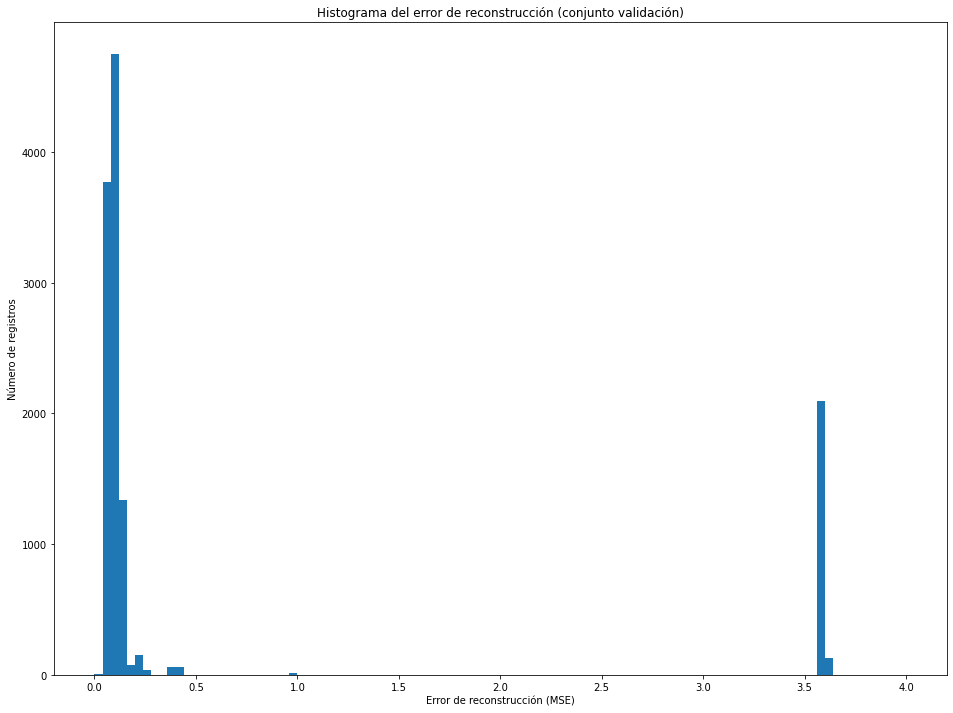

In [21]:
# Representamos en un histograma el error cometido para el conjunto de validacion (entre 0 y 10)
plt.hist(val_error_rec, bins=100, range=[0, 4])
plt.title('Histograma del error de reconstrucción (conjunto validación)')
plt.ylabel('Número de registros')
plt.xlabel('Error de reconstrucción (MSE)')
plt.show()

Para detectar las anomalías necesitamos fijar el umbral a partir del cual consideramos que el dato es una anomalía. El umbral (o *threshold*) se define generalmente como una desviación estándar por encima de la media del error de reconstrucción. Generalizando:

$$\textrm{threshold} = \overline{\textrm{mse}(X_{\textrm{val}} - X'_{\textrm{val}})} + N * \sigma_{\textrm{mse}(X_{\textrm{val}})}$$

Donde N es un valor entero que se puede modificar para ajustar mejor el umbral según el objetivo del problema.

In [22]:
# Calculamos valores necesarios para el umbral
mse_mean = np.mean(val_error_rec)
mse_std = np.std(X_val)

# Creamos dataframe donde almacenar los resultados
umbral_df = pd.DataFrame(columns=['N', 'threshold', 'val_acc'])

# Calculamos todos los parámetros solicitados y los almacenamos en el dataframe que hemos creado
for N in range(1,6):
    
    # Calculamos umbral de anomalía
    umbral = mse_mean + N * mse_std
    
    # Calculamos la accuracy de la validación
    val_pred_ae = autoencoder.predict(X_val)
    val_pred_mse = np.mean(np.power(X_val - val_pred_ae, 2), axis=1)
    val_pred_threshold = np.where(val_pred_mse > umbral, 1, 0)
    val_accuracy = accuracy_score(y_val, val_pred_threshold)

    umbral_df = umbral_df.append({'N': N, 'threshold': umbral, 'val_acc': val_accuracy}, ignore_index=True)
    
# Mostramos la tabla con todos los cálculos
umbral_df

N  threshold   val_acc
0  1.0   1.558712  0.822046
1  2.0   2.401924  0.822046
2  3.0   3.245136  0.822046
3  4.0   4.088348  1.000000
4  5.0   4.931560  1.000000

Como podemos comprobar, si definimos el valor del umbral (threshold) en 4.08, tendríamos contemplados todos nuestros eventos como normales, ya que la precisión de nuestro modelo sería del 100%. Los que superen ese umbral, serán los que se definan como anomalías.

No obstante, si miramos el histograma del error de reconstrucción para el conjunto de validación, podemos comprobar que la mayoría de nuestros eventos se sitúan entre los valores 0 y 0.5 del MSE. Según la tabla con los diferentes umbrales, si lo definimos en 1.55, tendremos una precisión del 82%. Por tanto, vamos a utilizar este umbral y todos aquellos eventos que lo superen, serán marcados como anomalía. De esta forma, estamos aumentando los valores de los falsos positivos, pero estamos reduciendo la posibilidad de falsos negativos, que es mucho más importante.

A continuación, vamos a almacenar nuestra red neuronal, el autoencoder, utilizando la función `save` que nos ofrece keras. Esta funcionalidad nos permite guardar y reutilizar un modelo entrenado.

In [23]:
autoencoder.save("../generador-eventos/dl_models/autoencoder.h5")

Por último, vamos a realizar el proceso de cargar un evento desde un fichero y determinar si se trata de una anomalía o no. Para ello, vamos a crear una función que lea todos los modelos que hemos almacenado y realice la predicción.

In [24]:
THRESHOLD = 1.558712

def load_and_tokenize_attribute(attribute, name):
    with open('../generador-eventos/dl_models/' + name + '.pickle', 'rb') as handle:
        t = pickle.load(handle)
        
    tokenized_attribute = t.texts_to_matrix(attribute, mode='count')
    
    return pd.DataFrame(tokenized_attribute)

def isAnomaly(event):
    event_df = pd.DataFrame(event, index=[1])
    
    attr_to_tokenize = ['eventID', 'processID', 'userName', 'domainName', 
                    'callerProcessName', 'longMessage', 'level', 'task']

    processed_event = pd.DataFrame()

    # Añadimos los datos procesados
    for attr in attr_to_tokenize:
        processed_event = pd.concat([processed_event, load_and_tokenize_attribute(event_df[attr], attr)], axis=1)
        
    threadID = event_df.iloc[:, 3].values

    with open('../generador-eventos/dl_models/threadID.pickle', 'rb') as handle:
        scaler = pickle.load(handle)

    processed_event['threadID'] = scaler.transform(threadID.reshape(-1,1))
    
    loaded_autoencoder = load_model('../generador-eventos/dl_models/autoencoder.h5')
    
    pred = loaded_autoencoder.predict(processed_event)
    anomaly_score = np.mean(np.power(processed_event - pred, 2), axis=1)
    return (anomaly_score.item() > THRESHOLD, anomaly_score.item())

def analyzed_event(event):
    anomaly = isAnomaly(event)
    event['anomaly'] = anomaly[0]
    event['anomalyScore'] = anomaly[1]
    return event

In [27]:
with open('../ejemplo-eventos-xml/events_pass_error.xml', 'r') as reader:
    raw_xml = reader.read()
    parsed_xml = ET.fromstring(raw_xml)
    
rows = []
for event in parsed_xml:
        e = EV.Event(event)
        row = analyzed_event(e.createRow())
        rows.append(row)
        
analyzed_data = pd.DataFrame(rows)

In [32]:
analyzed_data[['eventID', 'task', 'anomaly', 'anomalyScore']]

eventID   task  anomaly  anomalyScore
0    4625  Logon     True      2.413668

Como podemos ver, nuestra red neuronal nos ha clasificado este evento como anomalía. El evento que le hemos pasado a modo de prueba se trata de un evento con id 4625 y se trata de un error al introducir la contraseña para iniciar sesión. Este evento fue uno de los que filtramos y que queríamos que fuera detectado como anomalía, por lo que, en este caso, nuestro detector de anomalías ha funcionado correctamente.